# Text-Sentiment-Analysis-using-LSTM

<a href="https://colab.research.google.com/github/LuluW8071/Text-Sentiment-Analysis/blob/main/Text_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load the dataset

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
sentiment_to_int = {
	"positive": 2,
	"neutral": 1,
	"negative": 0
}

int_to_sentiment = {v: k for k, v in sentiment_to_int.items()}

# Reduce to 10000 samples if you want your model to train faster (while loss may increase)
samples = 20000

# Read dataset and take random 20000 samples
df = pd.read_csv("dataset.csv")
df = df.sample(n=samples, random_state=random.randint(0, 100))

# Reset the index
df.reset_index(drop=True, inplace=True)
df.head(), df.shape, df["language"].value_counts()[:5],df["label"].value_counts()

(                                                text language     label
 0  tryna did simple pvTT-TT so broken on text🥲ori...       en  negative
 1  @GruntledT @TweetingYet @CostaCoffee Police ar...       en   neutral
 2  Instead our primary focus is on establishing a...       en  positive
 3  @DOJ please enforce the law. Indict and prosec...       en   neutral
 4                       I need my back popped so bad       en  negative,
 (20000, 3),
 language
 en    18561
 fr      298
 es      263
 pt      220
 ja      171
 Name: count, dtype: int64,
 label
 neutral     8830
 positive    5668
 negative    5502
 Name: count, dtype: int64)

## 2. Data Analysis

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

train data shape: (18000,)
test data shape: (2000,)


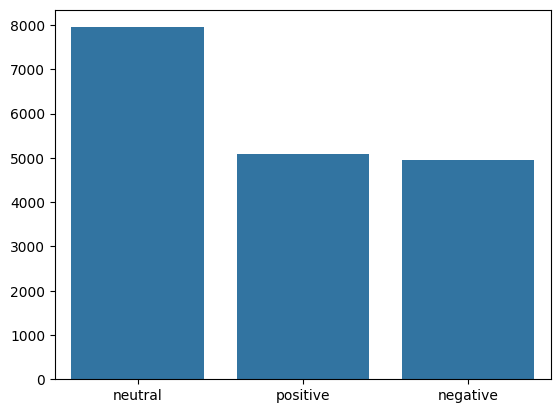

In [4]:
X, y = df['text'].values,df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.1)
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')


val = pd.Series(y_train).value_counts()
sns.barplot(x = np.array(["neutral", "positive", "negative"]),
            y = val.values)
plt.show()

## 3. Text Pre-Processing
- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words")
- Keeping track of the 1000 most frequently used words in the dataset
- Assigning tracked words a unique identifier, forming dictionary for one-hot encoding
- Ensuring all sequences have the same length by padding or truncating them as needed by 500 tokens

In [5]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mk473\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Precompile regular expressions for faster pre processing [improved by 50% in preprocess]
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
digits_pattern = re.compile(r"\d")
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = non_word_chars_pattern.sub('', s)
    # Replace all runs of whitespaces with single space
    s = whitespace_pattern.sub(' ', s)
    # Replace digits with no space
    s = digits_pattern.sub('', s)
    # Replace usernames with no space
    s = username_pattern.sub('', s)
    # Replace hashtags with no space
    s = hashtags_pattern.sub('', s)
    # Replace specific characters
    s = s.replace("https", "")
    s = s.replace("http", "")
    s = s.replace("rt", "")
    s = s.replace("-", "")
    # Replace <br /> with a space
    s = s.replace("<br />", " ")
    # Replace newline character with empty string
    s = s.replace("\n", "")
    return s

In [7]:
# Create a Tokenize including padding Function
def tokenize(X_train, y_train, X_val, y_val, seq_len):
    word_list = []
    stop_words = set(stopwords.words('english'))

    for sent in tqdm(X_train, desc="Preprocessing train data"):
        words = [preprocess_string(word) for word in sent.lower().split()]
        word_list.extend([word for word in words if word not in stop_words and word != ''])

    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # Creating a dictionary
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # Tokenize and pad sequences
    final_list_train = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                        for sent in tqdm(X_train, desc="Tokenizing and padding train data")]
    final_list_train = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                        for padded_tokens in final_list_train]

    final_list_test = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                       for sent in tqdm(X_val, desc="Tokenizing and padding validation data")]
    final_list_test = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len
                       else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                       for padded_tokens in final_list_test]

    encoded_train = np.array([sentiment_to_int[label] for label in y_train])
    encoded_test = np.array([sentiment_to_int[label] for label in y_val])

    return np.array(final_list_train), encoded_train, np.array(final_list_test), encoded_test, onehot_dict

In [8]:
seq_len = 300
X_train, y_train, X_test, y_test, vocab = tokenize(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   seq_len)

len(X_train), len(X_test)

Tokenizing and padding validation data: 100%|██████████| 2000/2000 [00:00<00:00, 18348.67it/s]


(18000, 2000)

In [9]:
X_train, y_train

(array([[  0,   0,   0, ...,  12,  42, 176],
        [  0,   0,   0, ..., 148,  55, 134],
        [  0,   0,   0, ...,  15,  34,  85],
        ...,
        [  0,   0,   0, ..., 430, 835, 443],
        [  0,   0,   0, ..., 792,  56, 513],
        [  0,   0,   0, ..., 124, 645, 109]]),
 array([1, 1, 1, ..., 0, 2, 2]))

## 4. Preparing the data using DataLoader

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [11]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train),
                           torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test),
                           torch.from_numpy(y_test))

BATCH_SIZE = 100

# Create train and valid dataloader
train_dataloader = DataLoader(train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

len(train_dataloader), len(valid_dataloader)

(180, 20)

In [12]:
# Sampling one bacth from train_dataloader
sample_data = iter(train_dataloader)
sample_x, sample_y = next(sample_data)

print('Sample input size:', sample_x.size())     # batch_size, seq_length
print('Sample input:', sample_x)
print('Sample output:', sample_y)

Sample input size: torch.Size([100, 300])
Sample input: tensor([[  0,   0,   0,  ...,  21,  87, 915],
        [  0,   0,   0,  ...,  10,  54,  67],
        [  0,   0,   0,  ..., 162,  25, 132],
        ...,
        [  0,   0,   0,  ..., 558, 365, 550],
        [  0,   0,   0,  ..., 754,  72, 887],
        [  0,   0,   0,  ..., 720,  42, 452]], dtype=torch.int32)
Sample output: tensor([0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 1, 1, 2, 1, 1,
        1, 2, 0, 1, 1, 1, 0, 1, 2, 0, 0, 2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1,
        0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 0, 1,
        0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2,
        1, 1, 0, 1], dtype=torch.int32)


## 5. Building a LSTM Model

<img src = "assets/LSTM-Model.png">

In [13]:
import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Here's a breakdown of how each component of the `SentimentLSTM` class processes the tokenized and padded array of text:

### Embedding Layer
The embedding layer (`self.embedding`) takes the tokenized and padded array of text as input. It converts each token (represented as an integer) into a dense vector of fixed size (`embedding_dim`). This dense representation captures semantic similarities between words. The input shape to the embedding layer is `(batch_size, sequence_length)`, where `batch_size` is the number of sequences in the batch and `sequence_length` is the length of each sequence.

### LSTM Layer
The LSTM layer (`self.lstm`) processes the embedded sequences over time. It takes the embedded input sequences and maintains hidden states to capture long-term dependencies. The LSTM layer consists of multiple LSTM units (determined by `no_layers`). Each LSTM unit processes one time step of the input sequence at a time. The input shape to the LSTM layer is `(batch_size, sequence_length, embedding_dim)`.

### Dropout Layer
The dropout layer (`self.dropout`) is applied after the LSTM layer. It helps prevent overfitting by randomly setting a fraction of input units to zero during training. This regularization technique improves the model's generalization performance. The input shape to the dropout layer is `(batch_size, sequence_length, hidden_dim)`.

### Fully Connected (Linear) Layer
The fully connected layer (`self.fc`) takes the output from the LSTM layer and transforms it into the desired output dimension (`output_dim`). It applies a linear transformation to the input data, followed by an optional bias term. The input shape to the fully connected layer is `(batch_size * sequence_length, hidden_dim)`.

### Sigmoid Activation Function
The sigmoid activation function (`self.sig`) is applied to the output of the fully connected layer. It squashes the output values to the range [0, 1], interpreting them as probabilities. In sentiment analysis, this allows the model to predict the probability of a given input belonging to a particular sentiment class (e.g., positive or negative). The output shape after applying the sigmoid function is `(batch_size * sequence_length)`.

In [14]:
class SentimentLSTM(nn.Module):
  def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim = 3):
    super(SentimentLSTM, self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size

    # Embedding and LSTM layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layer
    self.lstm = nn.LSTM(input_size = embedding_dim,
                        hidden_size = self.hidden_dim,
                        num_layers = no_layers,
                        batch_first = True)

    self.dropout = nn.Dropout(0.3)                    # Dropout Layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)  # Linear Layer
    self.softmax = nn.Softmax()

  def forward(self, x, hidden):
    """ Forward pass """
    batch_size = x.size(0)

    # Embeddings and lstm_out
    embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
    # print(embeds.shape)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    out = self.dropout(lstm_out)            # Dropout
    out = self.fc(out)                      # Fully connected layer

    softmax_out = self.softmax(out)             # Softmax
    softmax_out = softmax_out.view(batch_size, -1, self.output_dim)
    softmax_out = softmax_out[:, -1, :]         # get last batch of labels
    return softmax_out, hidden                  # return last softmax output and hidden state

  def init_hidden(self, batch_size):
    """ Initializes hidden state """
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # Initialized to zero, for hidden state and cell state of LSTM
    hidden_state = torch.zeros((self.no_layers,
                                batch_size,
                                self.hidden_dim)).to(device)
    # print(batch_size)
    cell_state = torch.zeros((self.no_layers,
                              batch_size,
                              self.hidden_dim)).to(device)
    hidden = (hidden_state, cell_state)
    # print("Hidden", hidden_state.size())
    # print("Cell", cell_state.size())
    return hidden

In [15]:
model = SentimentLSTM(no_layers = 3,               # LSTM doesn't perform quite well beyound 2 layers
                      vocab_size = len(vocab) + 1, # 1 extra for padding
                      hidden_dim = 256,
                      embedding_dim = 64)

# Pass model to device 'cuda' if selected
model.to(device)

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)

## 6. Create Train and Validation Loop Function

In [16]:
# Function to predict accuracy
def acc(pred, label):
  pred = torch.argmax(pred.squeeze(), dim=-1)
  return torch.sum(pred == label.squeeze()).item()

In [17]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, clip, device):
  valid_loss_min = np.Inf
  epoch_tr_loss, epoch_vl_loss = [], []
  epoch_tr_acc, epoch_vl_acc = [], []

  for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    # Initialize hidden state
    h = model.init_hidden(BATCH_SIZE)

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      # Creating new variables for the hidden state to prevent backpropagation
      # through the entire training history
      h = tuple([each.data for each in h])

      optimizer.zero_grad()
      output, h = model(inputs, h)
      loss = criterion(output.squeeze(), labels.long())
      loss.backward()

      train_losses.append(loss.item())
      accuracy = acc(output, labels)
      train_acc += accuracy
      clip_grad_norm_(model.parameters(), clip)
      optimizer.step()

    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()

    for inputs, labels in valid_loader:
      val_h = tuple([each.data for each in val_h])
      inputs, labels = inputs.to(device), labels.to(device)
      output, val_h = model(inputs, val_h)
      val_loss = criterion(output.squeeze(), labels.long())
      val_losses.append(val_loss.item())
      accuracy = acc(output, labels)
      val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch: {epoch+1} -- train_loss: {epoch_train_loss:.4f} -- train_acc: {epoch_train_acc*100:.2f}% -- val_loss: {epoch_val_loss:.4f} -- val_acc: {epoch_val_acc*100:.2f}%')

    # Saving model on each epoch except when valid_loss_for_next_epoch > valid_loss_for_prev_epoch
    if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), 'LSTM_sentiment_model.pth')
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
      valid_loss_min = epoch_val_loss
    print(25*'==')

  return epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc

## 7. Train and Evaluate the Model

In [18]:
# Loss function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [19]:
train_losses, val_losses, train_accs, val_accs = train_model(model = model,
                                                             train_loader = train_dataloader,
                                                             valid_loader = valid_dataloader,
                                                             criterion = loss_fn,
                                                             optimizer = optimizer,
                                                             epochs = 10,
                                                             clip = 5,
                                                             device = device)

c:\Users\mk473\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1 -- train_loss: 0.8214 -- train_acc: 72.07% -- val_loss: 0.6743 -- val_acc: 87.30%
Validation loss decreased (inf --> 0.674273).  Saving model ...
Epoch: 2 -- train_loss: 0.6470 -- train_acc: 90.21% -- val_loss: 0.6347 -- val_acc: 91.50%
Validation loss decreased (0.674273 --> 0.634733).  Saving model ...
Epoch: 3 -- train_loss: 0.6213 -- train_acc: 92.77% -- val_loss: 0.6168 -- val_acc: 93.05%
Validation loss decreased (0.634733 --> 0.616828).  Saving model ...
Epoch: 4 -- train_loss: 0.6115 -- train_acc: 93.76% -- val_loss: 0.6123 -- val_acc: 93.50%
Validation loss decreased (0.616828 --> 0.612278).  Saving model ...
Epoch: 5 -- train_loss: 0.6046 -- train_acc: 94.40% -- val_loss: 0.6075 -- val_acc: 93.90%
Validation loss decreased (0.612278 --> 0.607523).  Saving model ...
Epoch: 6 -- train_loss: 0.6005 -- train_acc: 94.74% -- val_loss: 0.6054 -- val_acc: 94.30%
Validation loss decreased (0.607523 --> 0.605378).  Saving model ...
Epoch: 7 -- train_loss: 0.6001 -- train_acc: 

## 8. Plot Loss and Accuracy Curves

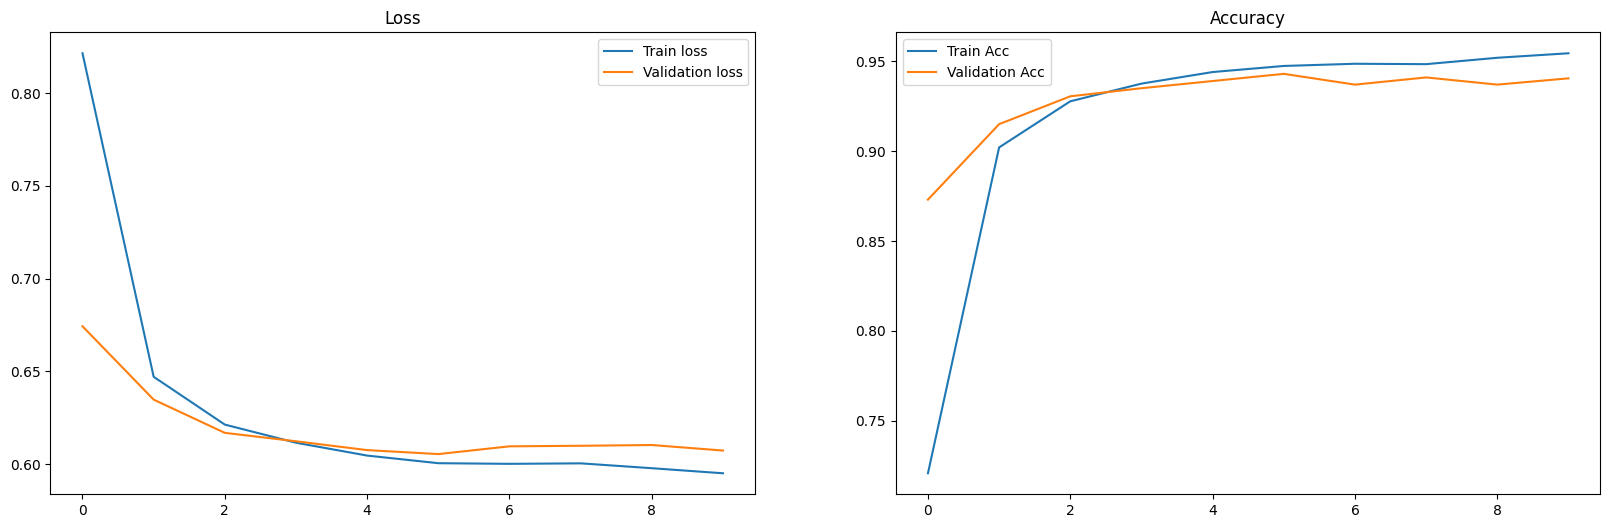

In [20]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.title("Accuracy")
plt.legend()

plt.show()

## 9. Load Model to `cpu`

In [22]:
# Load model configs
model = SentimentLSTM(no_layers = 3,
                      vocab_size = len(vocab) + 1,
                      hidden_dim = 256,
                      embedding_dim = 64)

# Load the model state dict
model.load_state_dict(torch.load("LSTM_sentiment_model.pth", map_location=device))

# Move the model to CPU
model.to('cpu')

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)

## 10. Make Prediction using Loaded Model

In [23]:
def padding_(seq, max_length):
    """Pad sequences to the same length"""
    if len(seq) >= max_length:
        return seq[:max_length]
    else:
        padded = np.zeros((seq.shape[0], max_length), dtype=int)
        padded[:, :seq.shape[1]] = seq
        return padded

def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq, axis=0)
    pad = torch.from_numpy(padding_(word_seq, 300))
    inputs = pad.to('cpu')  # Move inputs to CPU
    batch_size = 1
    h = model.init_hidden(batch_size)
    # Move the initial hidden state to CPU
    h = tuple([each.to('cpu') for each in h])
    # Set to evaluation mode
    with torch.inference_mode():
        output, h = model(inputs, h)
    return output.squeeze()

In [24]:
import random

# Randomly select 5 index from dataset to predict
for _ in range(5):
    index = random.randint(0, samples)
    text = df['text'][index]
    actual_sentiment = df['label'][index]

    print("Text:")
    print(text)
    print('='*70)
    print(f'Actual sentiment: {actual_sentiment}')
    print('='*70)
    pro = predict_text(text)
    print(pro)
    confidence, index = torch.max(pro, dim=-1)
    predicted_sentiment = int_to_sentiment[index.item()]

    # Color-coding output based on prediction matching actual sentiment
    if actual_sentiment == predicted_sentiment:
        color = '\033[92m'  # Green color for matching sentiment
    else:
        color = '\033[91m'  # Red color for mismatching sentiment

    print(f'Predicted sentiment: {color}{predicted_sentiment}\033[0m with a probability of {confidence * 100:.2f}%')
    print('='*70)

Text:
@tweetsonic @cardinalfan2251 @Pokemon You will pay 15$ to get the old Pokémon in the Switch just to wait a whole year and more months (so it will actually be 30$) just to use them in 2021 (if bother to put them in the possible game)???? You must be rich or stupid.
Actual sentiment: neutral
tensor([0.1493, 0.1568, 0.6938])
Predicted sentiment: positive with a probability of 69.38%
Text:
@ebruenig I just want to tell her not all straight guys are terribleprobably most of them are but still
Actual sentiment: neutral
tensor([0.0610, 0.0660, 0.8730])
Predicted sentiment: positive with a probability of 87.30%
Text:
DREAM小説シのあれこれを見ているのですが、根本的な問題は置いておいてお互いにフォロワー含めた空リプ鍵引用ゲスパーのし合いで。。。なんというか争いは同レベルのもののあいだでしかおこらないのだなあと
Actual sentiment: positive
tensor([0.1411, 0.0876, 0.7713])
Predicted sentiment: positive with a probability of 77.13%
Text:
Incredible tweet. And indeed, quite the conundrum https://t.co/tgJtFnOx47
Actual sentiment: positive
tensor([0.1066, 0.1040, 0.7895])
Predicted sentimen

In [25]:
def predict_custom_text(custom_text):
  pro = predict_text(custom_text)
  confidence, index = torch.max(pro, dim=-1)
  predicted_sentiment = int_to_sentiment[index.item()]
  print(f'Predicted: {predicted_sentiment} \nProbability {confidence * 100 :.2f}%')

In [26]:
# Custom Negative Text
custom_text = "I can't even begin to express my sheer frustration and utter disappointment with this product! It's an absolute disaster from start to finish. "
predict_custom_text(custom_text)

Predicted: positive 
Probability 75.81%


In [27]:
# Custom Positive Text
custom_text = "I recently watched a movie that completely exceeded my expectations. From the captivating storyline to the stellar performances of the cast, every aspect of the film was a delight. The characters were well-developed and relatable, each with their own unique charm that drew me into their world. The dialogue was witty and engaging, keeping me entertained from start to finish. Additionally, the stunning visuals and masterful cinematography added depth and richness to the viewing experience. Overall, it was a cinematic masterpiece that left me feeling uplifted and inspired. I highly recommend this movie to anyone looking for a heartwarming and enjoyable film."
predict_custom_text(custom_text)

Predicted: positive 
Probability 83.31%


In [28]:
i = [123, 345, 456, 678, 88888]

for i in range(len(i)):
  custom_text = df["text"][i]
  print("\nContext:", df["text"][i])
  print("Actual:", df["label"][i])
  predict_custom_text(custom_text)


Context: tryna did simple pvTT-TT so broken on text🥲original cover from https://t.co/4o9pQengvE https://t.co/b1ERxBsKZZ
Actual: negative
Predicted: positive 
Probability 72.02%

Context: @GruntledT @TweetingYet @CostaCoffee Police arrived - hence why I went quiet. I didn’t want them having my unlocked phone. Despite saying I was causing a Breach of the Peace Charge they were reluctant to arrest me. They did however call me “pathetic” and a “loser”. Each time I thanked him for compliment which seemed
Actual: neutral
Predicted: positive 
Probability 74.17%

Context: Instead our primary focus is on establishing a powerhouse brand and building associated value.We are excited to pioneer dynamic NFTs in this format into the space. Web3 is all about decentralisation and we want to apply that to the creative process of NFTs themselves.
Actual: positive
Predicted: positive 
Probability 73.35%

Context: @DOJ please enforce the law. Indict and prosecute Trump. https://t.co/mKWbuUnz2V
Actual: neu